In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyrealsense2 as rs
from sam2.build_sam import build_sam2_video_predictor

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

from superprimitive_fusion.demo import (
    get_frames,
    detect_yellow,
    segment_video,
    predict_geometry,
    delete_contents,
    crop_centre,
)

from superprimitive_fusion.scanner import (
    triangulate_rgbd_grid_grouped,
)

from superprimitive_fusion.utils import (
    plot_images,
)

In [2]:
device = torch.device("cuda")
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [15]:
TMP_VID_DIR = './tmp_vid/'
sam2_checkpoint = "../../models/SAM2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
vggt_crop = (518, 392)

In [4]:
vggt_model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)

In [5]:
sam2_predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [16]:
delete_contents(TMP_VID_DIR)
frames, keyframe_idx = get_frames()
for i,frame in enumerate(frames):
    plt.imsave(TMP_VID_DIR+f'{i}.jpg', crop_centre(frame, *vggt_crop))

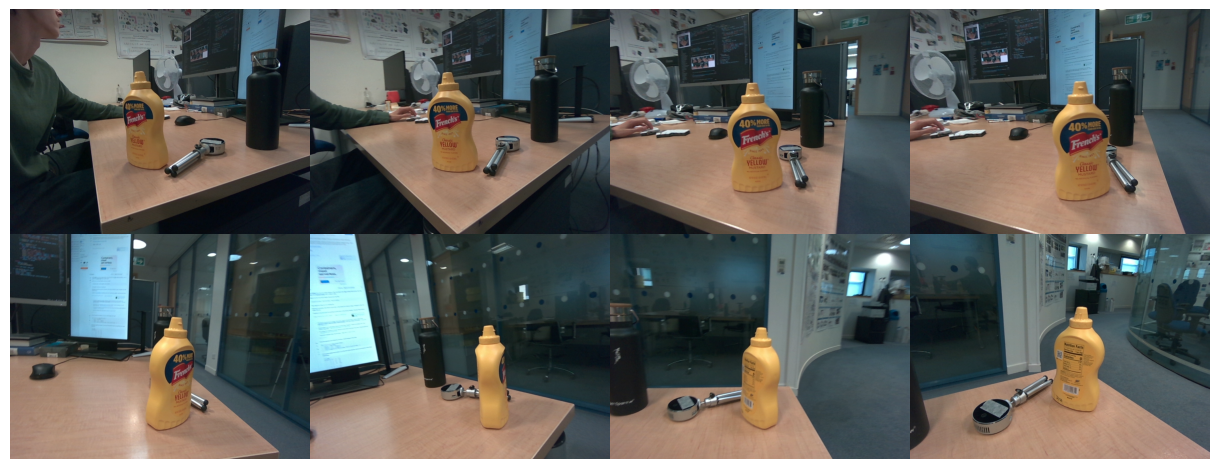

In [17]:
_=plot_images([frames[i] for i in keyframe_idx], max_cols=4)

In [18]:
points, conf, depth = predict_geometry(vggt_model, TMP_VID_DIR, None, device)

/home/christopher/Documents/Code/vggt/vggt/models/vggt.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [19]:
must_mask, must_centr = detect_yellow(plt.imread(TMP_VID_DIR+'0.jpg'))

In [34]:
vseg = segment_video(sam2_predictor, TMP_VID_DIR, must_centr, 0)
masks = np.array([vseg[i][1][0,...] for i in range(len(vseg))])

frame loading (JPEG):   0%|          | 0/29 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 29/29 [00:00<00:00, 87.75it/s]
/home/christopher/Documents/Code/segment-anything-2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/christopher/Documents/Code/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 29/29 [00:02<00:00, 14.41it/s]


In [53]:
import open3d as o3d
valid = (conf > 1.1) & (masks == 1)
# plt.imshow(valid[7])
i = 7
tris = triangulate_rgbd_grid_grouped(points[i], valid[i], depth[i], np.ones_like(masks[0]), k=10)

rgb = plt.imread(TMP_VID_DIR+f'{i}.jpg')

mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(points[i].reshape(-1,3))
mesh.triangles = o3d.utility.Vector3iVector(tris[1])
mesh.vertex_colors = o3d.utility.Vector3dVector(rgb.reshape(-1,3)/255)
mesh.remove_unreferenced_vertices()
o3d.visualization.draw_geometries([mesh])